In [1]:
# basic
import sys
import os

# common
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle

#lib
from lib.plots_base import basemap_ibtracs, basemap_var, basemap_scatter, axplot_basemap, basemap_scatter_both, plot_target_area,plot_predictor_grid
from lib.plots_tcs import get_storm_color, get_category, Plot_DWTs_tracks
from lib.plots_aux import data_to_discret, colors_dwt
from lib.extract_tcs import Extract_Rectangle, dwt_tcs_count
from lib.predictor_definition_building import *

import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

<br>
<br>
<br>

#  <font color='navy'>**3. Index Predictor Definition and Building** </font> 

>3.1 [Spatial and temporal domain ](#domain) <br> <br>
>3.2 [Predictor grid and data processing](#pg) <br> <br>
>3.3 [Index definition and computation](#dc)<br> <br><br> <br>













## <font color='royalblue'>**3.1 Spatial and temporal domain**</font> <a name="domain"></a>

<br />

**The predictor area spans around the islands of Tonga, Samoa and Fiji, from latitude 0º to 30º and from longitude 160º to 210º; far enough to be able to identify regional as well as local patterns. The calibration period (time domain) is defined from 1982 to 2019.**

In [2]:
# ibtracs v4 dictionary
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',}

lo_SP, la_SP = [130,250], [-60,0]

# predictor area
lo_area = [160, 210]
la_area = [-30, 0]

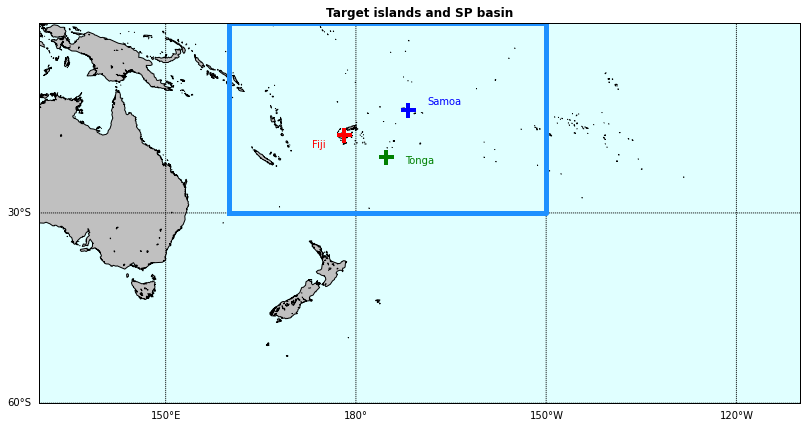

In [3]:
fig_target_area = plot_target_area(rectangle=[lo_area[0], lo_area[1], la_area[0], la_area[1]])

**The variables required for the methodology are downloaded from the databases:**

+ **Predictand**: Tropical cyclones tracks from IBTrACs, for the minimum pressure point.

+ **Predictor**: NOAA 1/4º daily Optimum Interpolation Sea Surface Temperature (SST) and Mixed Layer Depth (MLD) from the NCEP Climate Forecast System Reanalysis (CFSR).



In [3]:
path_st = r'/home/administrador/Documentos/'
xds_ibtracs, xds_SP = storms_sp(path_st)

All basins storms:  13481
SP basin storms:    1130 



In [3]:
# ibtracs v4 dictionary
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',}

lo_SP, la_SP = [130,250], [-60,0]

# predictor area
lo_area = [160, 210]
la_area = [-30, 0]

In [5]:
# extract rectangle, 772 a 780
TCs_rect_hist_tracks = Extract_Rectangle(xds_SP, lo_area[0], lo_area[1], la_area[0], la_area[1], d_vns) 


In [14]:
df0 = df_pressures(xds_ibtracs)
df0[6000:6010]

,st,time,lon,lat,pres
6000,9833,1987-02-12 12:00:00.000040448,139.125000,-15.225000,970.0
6001,9833,1987-02-12 18:00:00.000040448,139.817963,-15.790068,970.0
6002,9833,1987-02-13 00:00:00.000040448,140.160004,-16.719999,970.0
6003,9833,1987-02-13 06:00:00.000040448,140.032623,-17.892567,980.0
6004,9833,1987-02-13 12:00:00.000040448,139.699997,-19.200003,996.0
6005,9833,1987-02-13 18:00:00.000040448,139.480362,-20.108568,998.0
6006,9833,1987-02-14 00:00:00.000040448,139.399994,-21.100000,1001.0
6007,9835,1987-02-07 12:00:00.000040448,161.800003,-13.050001,990.0
6008,9835,1987-02-07 18:00:00.000040448,163.449997,-13.150000,995.0
6009,9835,1987-02-08 00:00:00.000040448,166.242844,-14.371429,997.0


In [3]:
#path to your daily mean SST and MLD data
path_sst = r'/media/administrador/SAMSUNG/seasonal_forecast/data/SST/'
path_mld = r'/media/administrador/SAMSUNG/seasonal_forecast/data/CFS/ocnmld/'
path_p = r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/'

**For the calibration period the points with pressure, SST and MLD data in the target area are kept.**

In [9]:
df = df_p_sst_mld(df0,path_sst,path_mld)
df_cali = df.drop(df.index[5184:]) #years of the calibration period

Start time:  2021-04-13 13:37:32.513946
End time:    2021-04-13 13:41:41.488278 



In [3]:
# load data
path_p= r'/home/administrador/Documentos/seasonal/seasonal_forecast/new/'
df = pd.read_pickle(path_p+'df_coordinates_pmin_sst_mld_2019.pkl')
df.tail()

,st,time,lon,lat,pres,sst,mld
14274,13348,2019-12-31 06:00:00.000039936,185.616379,-20.368277,999.0,25.750000,40.666668
14275,13348,2019-12-31 09:00:00.000039936,186.182968,-20.301870,999.0,25.199999,43.166664
14276,13348,2019-12-31 12:00:00.000039936,186.849609,-20.312431,1000.0,26.049999,42.666664
14277,13348,2019-12-31 15:00:00.000039936,187.731110,-20.379351,1000.0,27.029999,35.708336
14278,13348,2019-12-31 18:00:00.000039936,188.699997,-20.499998,1001.0,26.430000,42.999996


## <font color='royalblue'>**3.2 Predictor grid and data processing**</font> <a name="pg"></a>

<br />


**The historical datasets are interpolated into the a 1/2º grid resolution, defining this way the grid for the predictor in the target area.**


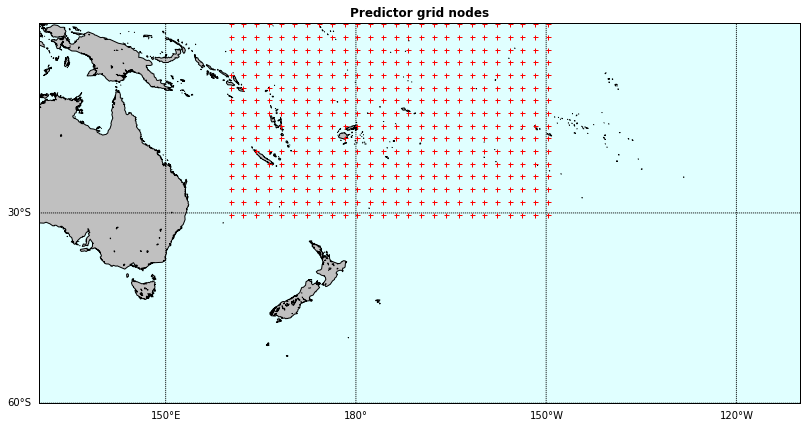

In [7]:
fig_predictor_grid = plot_predictor_grid()

**MLD, SST and pressure data plots:**

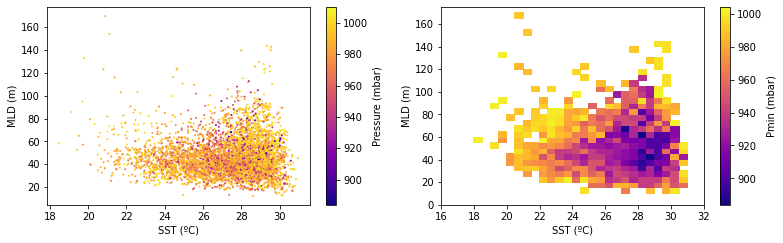

In [4]:
plot_sst_mlp_pmin_cali(df)

## <font color='royalblue'>**3.3 Index definition and computation**</font> <a name="dc"></a>

<br />

**The historic datasets are combined into the tailor-made index predictor.It built from the combination of SST-MLD-Pmin of the coordinate dataset previously generated, after being discretized in intervals of 0.5ºC and 5m for the SST and MLD respectively.For simplicity the index will range from 0 to 1 accounting for the Pmin limits of our dataset.**
<br>


In [51]:
# discretization: 0.5ºC (SST), 5m (MLD)
xx,yy,zz = data_to_discret(df['sst'].values, df['mld'].values, 0.5, 5, df['pres'].values, 15, 32, 0, 175, option='min')

# index function
index = zz
fmin, fmax = np.nanmin(zz), np.nanmax(zz)
index_zz = (fmax - index) / (fmax-fmin)

# remove nan
index_zz[np.isnan(index_zz)] = 0

<br>

<div style="padding: 15px; border: 1px solid transparent; border-color: transparent; margin-bottom: 20px; border-radius: 4px; color: rgb(0,0,0); background-color: #fcf8e3; border-color: #faebcc; ">

**The index predictor function:** <br>
    
**index<sub>i</sub> = (P<sub>max</sub> - P<sub>i</sub>) / (P<sub>max</sub> - P<sub>min</sub>)**

<br>

**The index plotted in the MLD-SST space:**

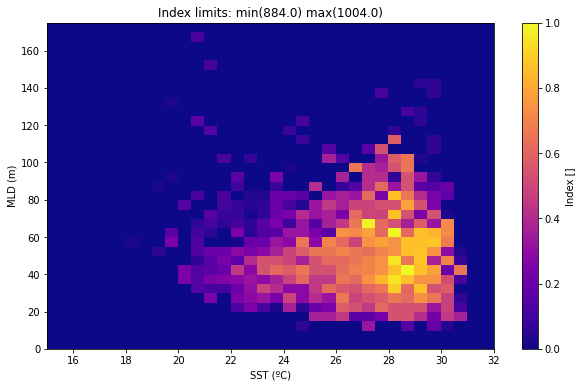

In [52]:
fig_index = plot_index(xx,yy,zz,index_zz)

**Final dataset including all the variable and the index predictor values in the predictor grid.**

In [24]:
xs = ds_index_sst_mld_calibration(path_sst,path_mld,df)

Start time:  2021-04-14 08:31:02.952802
End   time:  2021-04-14 08:31:14.467662
Merge time:  2021-04-14 08:38:58.435711 

<xarray.Dataset>
Dimensions:  (lat: 16, lon: 26, time: 13879)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2019-12-31
  * lat      (lat) float64 -0.25 -2.25 -4.25 -6.25 ... -26.25 -28.25 -30.25
  * lon      (lon) float64 160.2 162.2 164.2 166.2 ... 204.2 206.2 208.2 210.2
Data variables:
    index    (time, lat, lon) float64 0.3667 0.05833 0.0 ... 0.1167 0.2417 0.0
    sst      (time, lat, lon) float32 30.77 30.95 30.03 ... 23.1 22.85 22.9
    dbss     (time, lat, lon) float32 19.38 28.42 76.08 ... 24.33 23.88 19.75
    mask     (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0


In [13]:
path_slp = r'/media/administrador/SAMSUNG/seasonal_forecast/data/CFS/'
path_pp = r'/home/administrador/Documentos/pratel/'
path_trmm = r'/home/administrador/Documentos/TRMM_daily/'

In [47]:
xs = ds_index_sst_mld_slp_pp_calibration(path_pp,path_slp,xs)

Start time:  2021-04-14 09:21:34.904732
End   time:  2021-04-14 09:21:37.685073
Merge time:  2021-04-14 09:25:09.111452 



In [20]:
xs_trmm = ds_trmm(path_trmm)

Start time:  2021-04-19 15:21:32.682371
End   time:  2021-04-19 15:21:32.855106
Merge time:  2021-04-19 15:21:46.715566 

